# General configuration

##  User-specific paths to cross-section, CIA, and aerosols data files

In [1]:
from pathlib import Path

# Path where the data are stored
data_path: Path = Path('/home/gauravs/Untitled Folder/gsoc') / 'data'

xsec_path = (data_path / "corrk").as_posix()
cia_path = (data_path / "cia").as_posix()

In [2]:
xsec_path, cia_path

('/home/gauravs/Untitled Folder/gsoc/data/corrk',
 '/home/gauravs/Untitled Folder/gsoc/data/cia')

In [ ]:
## Opacity input file for H20 is:
## H2O__POKAZATEL__R1000_0.3-50mu.ktable.petitRADTRANS.h5
## This is at a resolution of 1000 and covers the range 0.3-50 microns.

## General Imports

In [4]:
import numpy as np

import astropy.units as u
import pytmosph3r as p3
import exo_k as xk

p3.criticalLogging() # disable most of the logging
xk.Settings().set_search_path(xsec_path)
xk.Settings().set_cia_search_path(cia_path)

#xk.Settings().set_delimiter(".")
xk.Settings().set_mks(True)
xk.Settings().set_log_interp(False)

# %matplotlib notebook

/home/gauravs/anaconda3/envs/grid/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In case you encounter a bug, you can use the following command to get more information from pytmosph3r:

In [6]:
p3.debug()
p3.criticalLogging()

# Simple transmission model configuration

## Planet & star

In [7]:
Rp = 1.807 * 6.9911e7 * u.Unit('m')
g0 = 6.67384e-11 * 1.183 * 1.898e27 / Rp**2 * u.Unit('m3*s-2')

orbit=p3.CircularOrbit(a=1.*u.au)
planet = p3.Planet(surface_gravity=g0, radius=Rp)
star = p3.Star.fromSolar(temperature=6460.0, radius=1.458) # radius is in sun radii

## Atmosphere

First, let's choose the dimensions of our atmospheric grid. Here, we will first test a 1D model:

In [8]:
grid = p3.Grid3D(n_vertical=100, n_latitudes=1, n_longitudes=1)

We can now set the temperature, pressure and gases to include in our atmosphere:

In [9]:
input_atmosphere = p3.InputAtmosphere(grid=grid,

     # Feel free to add a 1D temperature profile here instead
     temperature = 1500,

     # bottom and top pressures
     max_pressure = 1e6, min_pressure = 1e-4,

     # Again, you could add more complex molecular profiles if needed
     gas_mix_ratio = {"H2O":5.01187234e-04,
                      "H2":"background"
                     },
     # molecules for which we will not compute the opacity
     transparent_gases = "H2")

In [10]:
observer = p3.Observer(0, 180) # latitude, longitude in degrees
rays = p3.Rays(n_radial=100, n_angular=1) # in 1D cases, only 1 angle is required

## Opacity

In [11]:
opacity = p3.Opacity(rayleigh=True, cia=['H2'])

## Run the model

In [12]:
model = p3.Model(n_vertical = 100,
                 planet=planet,
                 star=star,
                 orbit=orbit,
                 observer=observer,
                 input_atmosphere=input_atmosphere,
                 transmission=p3.Transmission(rays=rays),
                 opacity=opacity,)

model.build()

In [13]:
model.run()

  0%|          | 0/1 [00:00<?, ?it/s]

### Variables in the model

In [14]:
model

 Model()
- Inputs: ['output_file', 'n_vertical', 'noise', 'interp', 'gas_dict', 'aerosols_dict', 'input_atmosphere', 'opacity', 'planet', 'star', 'observer', 'orbit', 'radiative_transfer', 'transmission', 'emission', 'lightcurve', 'phasecurve', 'parallel']
- Outputs: ['input_atmosphere', 'atmosphere', 'wns', 'wnedges', 'transmission', 'emission', 'lightcurve', 'phasecurve', 'spectrum_value', 'spectrum_noised']
- Methods: ['Rp', 'aerosol', 'available_memory', 'build', 'check_memory', 'critical', 'debug', 'default_value', 'dump_profiling', 'error', 'gas', 'info', 'inputs', 'inputs_values', 'isEnabledFor', 'outputs', 'override_data_file', 'override_file_param', 'read_data', 'run', 'search_path', 'start_profiling', 'summary', 'warning']

In [15]:
# get the wns and fluxes from the model 
wns = model.wns
fluxes = model.spectrum_value
fluxes = fluxes[::-1]
wns.shape, fluxes.shape

((5115,), (5115,))

In [19]:
## wavelength grid binning the model to different resolutions

def wl_grid_constant_R(wl_min, wl_max, R):
    '''
    Create a wavelength array with constant spectral resolution, 
    (R = wl/dwl).
    '''

    # Constant R -> uniform in log(wl)
    delta_log_wl = 1.0/R
    N_wl = (np.log(wl_max) - np.log(wl_min)) / delta_log_wl
    N_wl = np.around(N_wl).astype(np.int64)
    log_wl = np.linspace(np.log(wl_min), np.log(wl_max), N_wl)    

    wl = np.exp(log_wl)
    
    return wl

In [20]:
wl_r300 = wl_grid_constant_R(0.6, 10.0, 300)

In [21]:
from spectres import spectres
binned_spectra = spectres(wl_r300, wv, fluxes)

In [24]:
model.wnedges.min(), model.wnedges.max()

(200.05979270618224, 33310.111722469985)

In [25]:
resolution = 200
bingrid = xk.wavenumber_grid_R(model.wnedges.min(), model.wnedges.max(), resolution)
bingrid = xk.Spectrum(model.spectrum_value,model.wns,bingrid)
bingrid


        value        : [0.01765324 0.01792746 0.0172758  ... 0.01688656 0.01688747 0.01688838]
        wl (microns) : [49.96006377 49.91012867 49.86024349 ...  0.30096056  0.30065975
  0.30035924]
        

## Plot the spectrum

Saved to `outputs/spectrum_pytmosph3r.pdf`


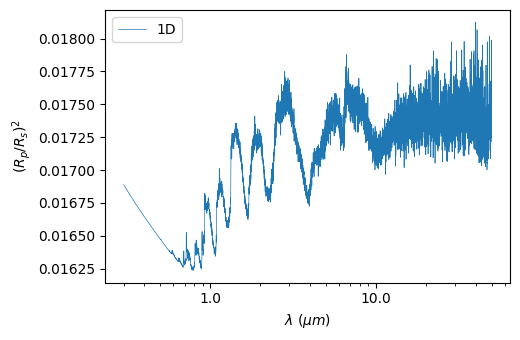

In [28]:
plot = p3.Plot(model=model, label="1D", interactive=True, out_folder="outputs")
plot.plot_spectrum()

The spectrum can be binned down to a specific number of wavelengths:

Saved to `outputs/spectrum_pytmosph3r.pdf`


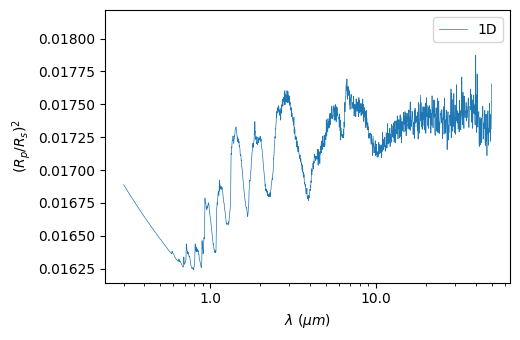

In [29]:
plot.plot_spectrum(resolution=300)

Saved to `outputs/spectrum_pytmosph3r.pdf`


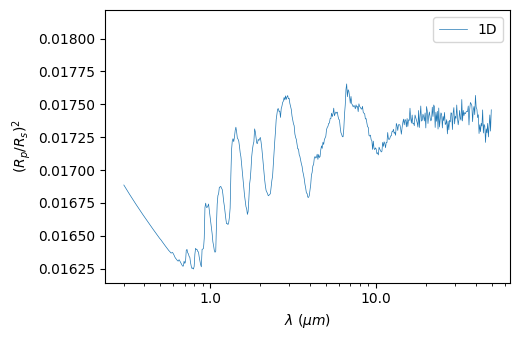

In [30]:
plot.plot_spectrum(resolution=100)


# Generate 10000 transmission models

In [31]:
## Function to get the transmission spectra for a given H2O mixing ratio
def get_trans_spectra(logH2O):
    input_atmosphere.gas_mix_ratio['H2O'] = 10**logH2O
    model = p3.Model(n_vertical = 100,
                 planet=planet,
                 star=star,
                 orbit=orbit,
                 observer=observer,
                 input_atmosphere=input_atmosphere,
                transmission=p3.Transmission(rays=rays),
                 opacity=opacity,)
    model.build()
    model.run()
    wls = model.spectrum.wls
    wls = wls[::-1]
    fluxes = model.spectrum.value
    fluxes = fluxes[::-1]
    return wls, fluxes

In [ ]:
import multiprocessing
from spectres import spectres

## Generating 10000 random values of logH20 in the range -7 to 0 
## which corrresponds to volume mixing ratio of H2O of 1e-7 to 1
log_h20_params = np.random.uniform(-7, 0, 10000).reshape(10000, 1)

def my_function(i):
    wls, flux = get_trans_spectra(log_h20_params[i])
    return flux

if __name__ == '__main__':
    samples = log_h20_params
    num_processors = 30
    with multiprocessing.Pool(num_processors) as pool:
        trans_spectras = pool.map(my_function, range(len(samples)))

# saving the generated forward models and the corresponding parameters and wavelenghts 
path_gsoc_data = '/home/gauravs/Untitled Folder/gsoc/outputs/'
np.save(path_gsoc_data+'trans_spectras_r1000',trans_spectras)
np.save(path_gsoc_data+'params_logH20',log_h20_params)
np.save(path_gsoc_data+'wls_r1000',wls)


In [55]:
trans_spectras = np.array(trans_spectras)
trans_spectras.shape

(10000, 5115)